In [8]:
import tensorflow as tf
from numba import cuda

# Clear TensorFlow session and free memory
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

# Clear GPU memory (if using CUDA)
device = cuda.get_current_device()
device.reset()

In [2]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and prepare data
df = pd.read_csv("synthetic_name_variations_500_well_shuffled.csv")
df['text'] = "Original: " + df['input_name'] + " ; Translation: " + df['variation']
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [3]:
# 2. Initialize tokenizer and model with explicit config
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Create model with proper initialization
model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels=1,
    from_pt=True  # Important for compatibility
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# 3. Tokenization function
def tokenize_data(texts, labels=None, max_length=128):
    tokenized = tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )
    if labels is not None:
        return tokenized, tf.reshape(tf.cast(labels.values, tf.float32), [-1, 1])
    return tokenized



In [5]:
# Prepare datasets
train_data, train_labels = tokenize_data(train_df['text'], train_df['label'])
test_data, test_labels = tokenize_data(test_df['text'], test_df['label'])

# 4. Custom training loop to avoid compatibility issues
optimizer = Adam(learning_rate=3e-5)
loss_fn = BinaryCrossentropy(from_logits=True)

# Convert to TF Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': train_data['input_ids'],
     'attention_mask': train_data['attention_mask']},
    train_labels
)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': test_data['input_ids'],
     'attention_mask': test_data['attention_mask']},
    test_labels
)).batch(16)


In [6]:

# Training parameters
epochs = 10
best_auc = 0
patience = 3
wait = 0

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

  # Training
    for batch in train_dataset:
        with tf.GradientTape() as tape:
            outputs = model(batch[0], training=True)
            loss = loss_fn(batch[1], outputs.logits)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Evaluation
    y_true, y_probs = [], []
    for batch in test_dataset:
        outputs = model(batch[0])
        y_true.extend(batch[1].numpy().flatten())
        y_probs.extend(tf.sigmoid(outputs.logits).numpy().flatten())

    # Calculate metrics
    y_pred = (np.array(y_probs) > 0.5).astype(int)
    print(classification_report(y_true, y_pred, target_names=["Bad (0)", "Good (1)"]))

    # ROC/AUC using sklearn (works across TF versions)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    current_auc = auc(fpr, tpr)
    print(f"Validation AUC: {current_auc:.4f}")

    # Early stopping
    if current_auc > best_auc:
        best_auc = current_auc
        best_weights = model.get_weights()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"\nEarly stopping at epoch {epoch + 1}")
            break

# Load best weights
model.set_weights(best_weights)


Epoch 1/10
              precision    recall  f1-score   support

     Bad (0)       1.00      0.04      0.08        47
    Good (1)       0.51      1.00      0.67        46

    accuracy                           0.52        93
   macro avg       0.75      0.52      0.38        93
weighted avg       0.76      0.52      0.37        93

Validation AUC: 0.8154

Epoch 2/10
              precision    recall  f1-score   support

     Bad (0)       0.74      0.36      0.49        47
    Good (1)       0.57      0.87      0.69        46

    accuracy                           0.61        93
   macro avg       0.66      0.62      0.59        93
weighted avg       0.66      0.61      0.59        93

Validation AUC: 0.7831

Epoch 3/10
              precision    recall  f1-score   support

     Bad (0)       0.81      0.81      0.81        47
    Good (1)       0.80      0.80      0.80        46

    accuracy                           0.81        93
   macro avg       0.81      0.81      0.81   

In [7]:
# 5. Final evaluation
print("\nFinal Evaluation:")
y_true, y_probs = [], []
for batch in test_dataset:
    outputs = model(batch[0])
    y_true.extend(batch[1].numpy().flatten())
    y_probs.extend(tf.sigmoid(outputs.logits).numpy().flatten())

y_pred = (np.array(y_probs) > 0.5).astype(int)
print(classification_report(y_true, y_pred, target_names=["Bad (0)", "Good (1)"]))



Final Evaluation:
              precision    recall  f1-score   support

     Bad (0)       0.81      0.81      0.81        47
    Good (1)       0.80      0.80      0.80        46

    accuracy                           0.81        93
   macro avg       0.81      0.81      0.81        93
weighted avg       0.81      0.81      0.81        93



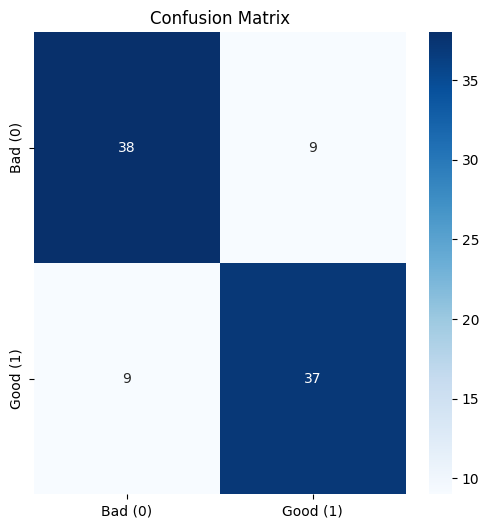

In [8]:
# Confusion matrix
plt.figure(figsize=(6,6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Bad (0)", "Good (1)"],
            yticklabels=["Bad (0)", "Good (1)"])
plt.title("Confusion Matrix")
plt.show()


In [22]:

# 6. Predict on examples
test_cases = [
    ("fatima zahra", "فاطمة الزهراء", 1),
    ("Bad Example", "ترجمة خاطئة", 0),
    ("Jean Dupont", "جان دوبوان", 0),
    ("Jean Dupont", "جان دوبون",1),
    ("fatima zahra", "كلبة فاطمة الزهراء", 0),
    ("Xiao Long", "شياو كلب", 0),
    ("mohammed", "محمود", 0),
    ("mohammed neji dridi","محمود ناجي الدريدي",0),
    ("asma al-najjar","أسماء نجر",0),
    ("asma al-najjar","أسماء النجر",0),
    ("asma al-najjar","أسماء النجار",1),
    ("nur mezni","نور المازني",1),
    ("nour mezni","نور مازني",1),
    ("Алексей","أليكسي",1),
    ("明伟","مينع وي",1)
]

print("\nCustom Test Cases:")
for name, trans, _ in test_cases:
    inputs = tokenizer(
        f"Original: {name} ; Translation: {trans}",
        return_tensors="tf",
        padding=True,
        truncation=True,
        max_length=128
    )
    outputs = model(inputs)
    prob = tf.sigmoid(outputs.logits).numpy()[0][0]
    print(f"{name} → {trans}: {'GOOD' if prob > 0.91 else 'BAD'} (confidence: {prob:.2%})")


Custom Test Cases:
fatima zahra → فاطمة الزهراء: GOOD (confidence: 91.72%)
Bad Example → ترجمة خاطئة: BAD (confidence: 44.86%)
Jean Dupont → جان دوبوان: GOOD (confidence: 91.38%)
Jean Dupont → جان دوبون: GOOD (confidence: 91.07%)
fatima zahra → كلبة فاطمة الزهراء: GOOD (confidence: 91.62%)
Xiao Long → شياو كلب: BAD (confidence: 69.52%)
mohammed → محمود: BAD (confidence: 90.73%)
mohammed neji dridi → محمود ناجي الدريدي: BAD (confidence: 90.67%)
asma al-najjar → أسماء نجر: BAD (confidence: 24.30%)
asma al-najjar → أسماء النجر: BAD (confidence: 90.20%)
asma al-najjar → أسماء النجار: GOOD (confidence: 91.28%)
nur mezni → نور المازني: BAD (confidence: 89.32%)
nour mezni → نور مازني: BAD (confidence: 88.81%)
Алексей → أليكسي: BAD (confidence: 66.89%)
明伟 → مينع وي: BAD (confidence: 19.78%)
